## Vmax tracking using IBTrACS

TODO: 

- Asymmetry information?

- IBTrACS or EBTRK? ==> JTWC Best-Tracks

- Latent parameter?

In [1]:
# General
# import glob
import os.path
# import warnings
# warnings.filterwarnings('ignore')
from tqdm import tqdm

# Arrays & Displays
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
# from mpl_toolkits.axes_grid1 import make_axes_locatable
# # from matplotlib.colors import Normalize
# # from matplotlib.colors import ListedColormap
# # import matplotlib.cm as cm
# import pandas as pd

# PyTorch
import torch
import torch.nn as nn
from torch.autograd import Variable              # Convert arrays to tensors
from torch.utils.data import Dataset, DataLoader # Create a Dataset class to combine with DataLoader (= mini batches selection)
import pytorch_lightning as pl

# Data treatment
# import dask as da
# from dask.diagnostics import ProgressBar
# import zarr
# from scipy.interpolate import griddata
from datetime import datetime

# Custom
import dataUtils    as du
import pytorchUtils as pu

# Statistics
from sklearn import linear_model, neighbors
from pykalman import KalmanFilter

# Default parameters
mpl.rcParams.update({'font.size': 18})
mpl.rcParams['figure.figsize'] = (15, 10)
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['figure.facecolor'] = 'white'

In [2]:
### Setup device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))
print('{} GPU(s) available'.format(torch.cuda.device_count()))

Using cuda device
1 GPU(s) available


In [3]:
### VARIABLES TO CONSIDER
'''Initial dataset has 147 variables, so we select only a subset of these'''
# storm speed, time, dist2land, usa_r64, usa_r50
params_of_interest = ['usa_lon', 'usa_lat', 'usa_wind', 'usa_r34', 'usa_rmw'] 
input_variables    = ['usa_lon', 'usa_lat', 'usa_wind', 'usa_r34'] 
target_variable    = ['usa_rmw']
additional_info    = ['numobs', 'sid', 'basin', 'name', 'usa_agency', 'iso_time', 'usa_status']

### PARAMS
PARAMS = {'input_size':  len(input_variables),
          'output_size': len(target_variable),
          'seq_len':     360,  
          
          'hidden_size': 20,    # nb of features in hidden state
          'num_layers':  2,     # nb of stacked lstm layers
          'dropout':     0,     # dropout probability
    
          'batch_size':  1,     
          'n_epochs':    50,     # nb of epochs
          'learn_rate':  0.001,  # learning rate
          
          'save_figs':       False,
          'feature_scaling': True,
         }

### PATHS
PATHS  = {
    # Data
    'ibtracs_data': '/home/arthur/data/ibtracs/IBTrACS.NA.v04r00.nc', # '/home/arthur/data/ibtracs/IBTrACS.NA.v04r00.nc'
    # Save
    'lstm_path':    '/home/arthur/results/TCsLifeMonitFromObs/rmax_seq_pred_ibtracs/lstmv02.pth',
    'save_path':    '/home/arthur/results/TCsLifeMonitFromObs/kalman/',
}

In [4]:
### OPEN DATASET
ds_ibt_raw = xr.open_dataset(PATHS['ibtracs_data'])
ds_ibt     = ds_ibt_raw[params_of_interest + additional_info]
# ds_ibt_raw

In [5]:
# ds_ibt_raw.isel(storm=25)['usa_rmw']

In [6]:
### FILTERS
# Convert to m/s and km units
ds_ibt['usa_wind'] *= 0.5144
ds_ibt['usa_r34']  *= 1.852
ds_ibt['usa_rmw']  *= 1.852

### 1) FILTERS BY YEAR, EMPTY R34, CATEGORY, RMAX INTERESTING TIME SERIES
# By year
start_date = np.datetime64('2000-01-01')
fsi        = np.nanargmin(np.abs(ds_ibt['time'][:, 0] - start_date)) # First storm index
ds_ibt     = ds_ibt.isel(storm=slice(fsi, -1))
# Average by quadrant (R34 assumption)
ds_ibt     = ds_ibt.mean(dim='quadrant', skipna=True)
# By category
for s in tqdm(range(len(ds_ibt['storm']))):
    da = ds_ibt.isel(storm=s)['usa_wind']
    if da.max(dim='date_time', skipna=True) < 33: # >= Cat.1 according to Saffir Simpson scale, 64 is in knts
        ds_ibt.isel(storm=s)['usa_wind'] *= np.nan  

# # Keep only interesting time series, i.e containing sufficiently long sequences of valid Rmax values
for s in tqdm(range(len(ds_ibt['storm']))):
    da = ds_ibt.isel(storm=s)['usa_rmw']
    # Longest valid sequence
    # if np.max(np.diff(np.where(np.isnan(da)))) < 8: # Count maximum valid sequence and filter it out if less than 1 day
    #     ds_ibt.isel(storm=s)['usa_rmw'] *= np.nan
    # Number of valid values
    if np.count_nonzero(~np.isnan(da)) < 24: # Count the number of valid usa_rmw values and filter it out if less than 24 values
        ds_ibt.isel(storm=s)['usa_rmw'] *= np.nan   
# Drop NaNs
ds_ibt = ds_ibt.dropna(dim='storm', how='all', subset=['usa_wind']) # Much quicker to drop NaNs only at the end
ds_ibt = ds_ibt.dropna(dim='storm', how='all', subset=['usa_rmw']) 
ds_ibt = ds_ibt.dropna(dim='storm', how='all', subset=['usa_r34'])

print("Total samples after (1): ", len(ds_ibt['storm']))

### 2) FINAL DATASET
### Keep longest valid sequence if it represents more than 60% of the TC life cycle
# Both for RMW and R34
life_cyc_percent_thresh = 0.6

for s in tqdm(range(len(ds_ibt['storm']))):
        ds      = ds_ibt.isel(storm=s)
        # Compute life cycle length
        cyc_len = np.where(np.isnan(ds['usa_lat']))[0][0]
        for param in ['usa_r34', 'usa_rmw']:
            # Compute length of longest valid sequence
            val_len = np.max(np.diff(np.concatenate(([0], np.where(np.isnan(ds[param]))[0]), axis=0)))
            if val_len < life_cyc_percent_thresh * cyc_len:
                # print('Index {}, Cyc_len = {}, val_len = {}'.format(s, cyc_len, val_len))
                ds[param] *= np.nan
                
ds_ibt = ds_ibt.dropna(dim='storm', how='all', subset=['usa_rmw']) 
ds_ibt = ds_ibt.dropna(dim='storm', how='all', subset=['usa_r34'])

print("Total samples after (2): ", len(ds_ibt['storm']))                

100%|███████████████████████████████████████| 394/394 [00:00<00:00, 1165.15it/s]


Total samples after (1):  143


100%|████████████████████████████████████████| 143/143 [00:00<00:00, 828.58it/s]

Total samples after (2):  110


In [7]:
### CREATE DATASET

# final_params = ['usa_wind', 'usa_rmw', 'usa_r34', 'fcor']
final_params = ['usa_wind', 'usa_wind_diff', 'usa_rmw', 'usa_rmw_diff', 'usa_r34', 'usa_r34_diff', 'fcor']

def coriolis(lat):
    '''Latitude must be in degrees.'''
    Omega = 7.2921e-5                             # Earth rotation vector
    f     = 2 * Omega * np.sin(lat * np.pi / 180) # Coriolis parameter at lat° latitude and assuming it's constant 
    return f

def create_Xt_1_and_Xt(ds_ibt, fcor_boost=1):
    '''So far, fcor is boosted by 1e6'''
    Xt_1 = [] # shape (n_samples, n_features)
    Xt   = [] # shape (n_samples, n_targets)
    
    # For each storm, build Xt_1 and Xt dataset.
    for s in tqdm(range(len(ds_ibt.storm))):
        # Select storm
        ds = ds_ibt.isel(storm=s)
        # Add derivatives
        for p in ['usa_rmw', 'usa_r34', 'usa_wind']:
            ds['{}_diff'.format(p)]     = ds[p] * np.nan
            ds['{}_diff'.format(p)][1:] = ds[p].diff(dim='date_time')
        # Add Coriolis
        ds['fcor'] = coriolis(np.abs(ds['usa_lat'])) * fcor_boost
        # Get only valid stime steps
        ds         = ds.dropna(dim='date_time', subset=params_of_interest + ['usa_rmw_diff', 'usa_r34_diff', 'usa_wind_diff'])

        # Add to X and Y dataset
        # final_params = ['usa_wind', 'usa_rmw', 'usa_r34', 'fcor']
        final_params = ['usa_wind', 'usa_wind_diff', 'usa_rmw', 'usa_rmw_diff', 'usa_r34', 'usa_r34_diff', 'fcor']
        da           = ds[final_params].to_array().transpose()
        # print(da)
        for t in range(len(da['date_time']) - 1):
            Xt_1.append(da[t, :].values)
            Xt.append(da[t + 1, :].values)
        # print(Xt)
    
    # Convert to arrays
    Xt_1 = np.array(Xt_1)
    Xt   = np.array(Xt)
    
    return Xt, Xt_1

def normalize(Xt, Xt_1=0):
    mu_Xt_1 = np.mean(Xt_1, axis=0)  
    sg_Xt_1 = np.std(Xt_1, axis=0)
    mu_Xt   = np.mean(Xt, axis=0)
    sg_Xt   = np.std(Xt, axis=0)

    Xt_1    = (Xt_1 - mu_Xt_1) / sg_Xt_1
    Xt      = (Xt   - mu_Xt)   / sg_Xt
    return Xt_1, Xt, mu_Xt_1, sg_Xt_1, mu_Xt, sg_Xt

def unNormalize(X, mu, sg):
    return (sg * X) + mu

def rmse(X, Y):
    return np.sqrt(np.mean((X - Y) ** 2))
    
# Create dataset
fcor_boost=1e5
Xt, Xt_1 = create_Xt_1_and_Xt(ds_ibt, fcor_boost=fcor_boost)
    
# Normalize
# Xt_1, Xt, mu_Xt_1, sg_Xt_1, mu_Xt, sg_Xt = normalize(Xt, Xt_1)

# Linear model 
from sklearn.linear_model import LinearRegression
reg_mlr = LinearRegression(fit_intercept=False)
reg_mlr.fit(Xt_1, Xt)
M       = reg_mlr.coef_
print('M = \n' + str(np.around(M, 2)))

# Compute covariance of model
Q = np.cov((Xt - reg_mlr.predict(Xt_1)).T)
print('Q = \n' + str(np.around(Q, 2)))

# UnNormalize
# Xt_1 = unNormalize(Xt_1, mu_Xt_1, sg_Xt_1)
# Xt   = unNormalize(Xt,   mu_Xt,   sg_Xt)

# Compute covariance of observations
# H = np.eye(M.shape[0])
H = np.array([[1, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0],
              [0, 0, 1, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 1, 0, 0],
              [0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 1],
])

R = 0.1 * np.diag(np.nanstd(Xt_1, axis=0))

# # To use covariance
# A       = np.expand_dims(Xt_1, axis=2) # Compute R using dataset
# A_T     = np.transpose(A, (0, 2, 1))
# product = np.einsum('ijk, ikl -> ijl', A, A_T)
# R       = np.nanmean(product, axis=0)

# # To use correlations
# STDs    = np.dot(np.expand_dims(np.nanstd(Xt_1, axis=0), axis=1), np.expand_dims(np.nanstd(Xt_1, axis=0), axis=0))
# R       = np.divide(R, STDs)

100%|█████████████████████████████████████████| 110/110 [00:02<00:00, 38.08it/s]

M = 
[[ 1.    0.75  0.   -0.   -0.    0.    0.01]
 [-0.    0.75  0.   -0.   -0.    0.    0.01]
 [-0.05 -0.32  0.96  0.58  0.01  0.02  0.47]
 [-0.05 -0.32 -0.04  0.58  0.01  0.02  0.47]
 [ 0.03  0.59 -0.01  0.08  0.99  0.4   0.4 ]
 [ 0.03  0.59 -0.    0.07 -0.01  0.4   0.4 ]
 [ 0.   -0.   -0.    0.    0.    0.    1.01]]
Q = 
[[ 1.6000e+00  1.6000e+00 -7.7000e-01 -7.7000e-01  1.3000e+00  1.3400e+00
  -0.0000e+00]
 [ 1.6000e+00  1.6000e+00 -7.7000e-01 -7.8000e-01  1.2700e+00  1.3400e+00
  -0.0000e+00]
 [-7.7000e-01 -7.7000e-01  6.9190e+01  6.9110e+01  3.0710e+01  3.0790e+01
   2.0000e-02]
 [-7.7000e-01 -7.8000e-01  6.9110e+01  6.9130e+01  3.0640e+01  3.0790e+01
   1.0000e-02]
 [ 1.3000e+00  1.2700e+00  3.0710e+01  3.0640e+01  2.7083e+02  2.6377e+02
   1.3000e-01]
 [ 1.3400e+00  1.3400e+00  3.0790e+01  3.0790e+01  2.6377e+02  2.6761e+02
   1.2000e-01]
 [-0.0000e+00 -0.0000e+00  2.0000e-02  1.0000e-02  1.3000e-01  1.2000e-01
   0.0000e+00]]


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 34.97it/s]


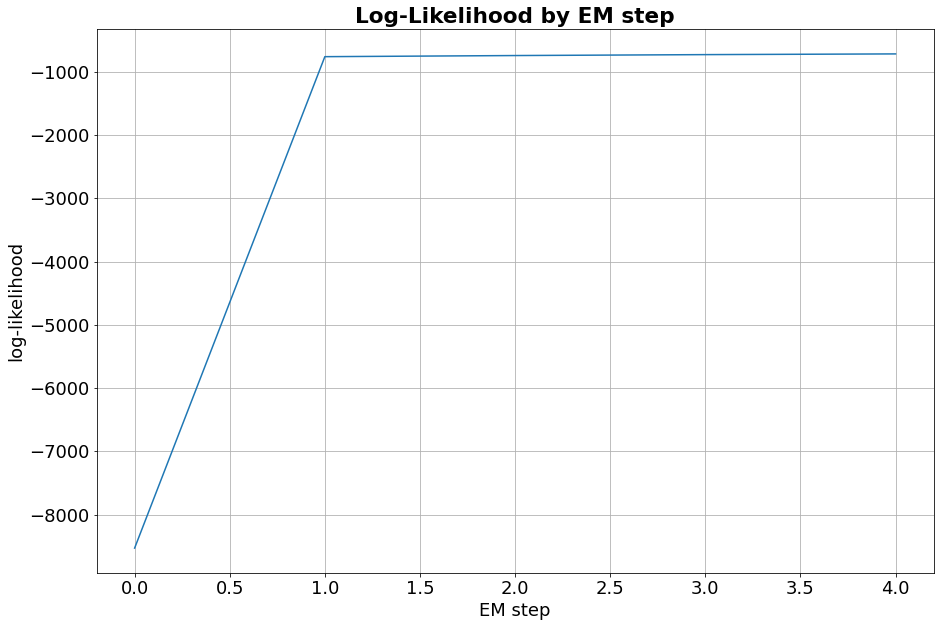

Estimated M:
[[ 0.96  0.72 -0.    0.01 -0.01  0.02  0.55]
 [-0.04  0.72 -0.    0.01 -0.01  0.02  0.55]
 [-0.38 -0.13  0.9   0.41  0.05 -0.05  1.97]
 [-0.38 -0.13 -0.1   0.41  0.05 -0.05  1.97]
 [ 0.87 -1.79  0.24 -0.4   0.89  0.08 -3.23]
 [ 0.85 -1.75  0.24 -0.39 -0.11  0.08 -3.14]
 [-0.    0.01  0.   -0.   -0.    0.    1.02]]
Estimated Q:
[[ 1.9500e+00  1.9500e+00 -5.4400e+00 -5.4400e+00  9.2800e+00  9.1000e+00
  -0.0000e+00]
 [ 1.9500e+00  1.9500e+00 -5.4300e+00 -5.4400e+00  9.2400e+00  9.0900e+00
  -0.0000e+00]
 [-5.4400e+00 -5.4300e+00  1.3846e+02  1.3832e+02 -3.1710e+01 -2.9830e+01
  -5.0000e-02]
 [-5.4400e+00 -5.4400e+00  1.3832e+02  1.3829e+02 -3.1760e+01 -2.9810e+01
  -5.0000e-02]
 [ 9.2800e+00  9.2400e+00 -3.1710e+01 -3.1760e+01  2.5620e+02  2.4813e+02
   2.1000e-01]
 [ 9.1000e+00  9.0900e+00 -2.9830e+01 -2.9810e+01  2.4813e+02  2.5102e+02
   2.0000e-01]
 [-0.0000e+00 -0.0000e+00 -5.0000e-02 -5.0000e-02  2.1000e-01  2.0000e-01
   0.0000e+00]]
Estimated R:
[[ 1.6600e+00  2.3600

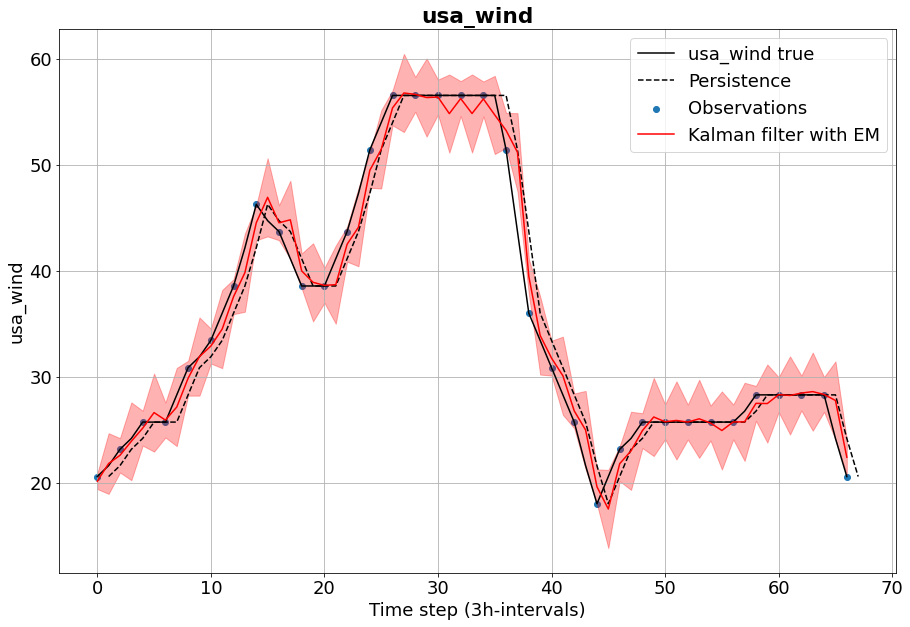

RMSE persistence   = 2.4
RMSE Kalman smooth = 1.0


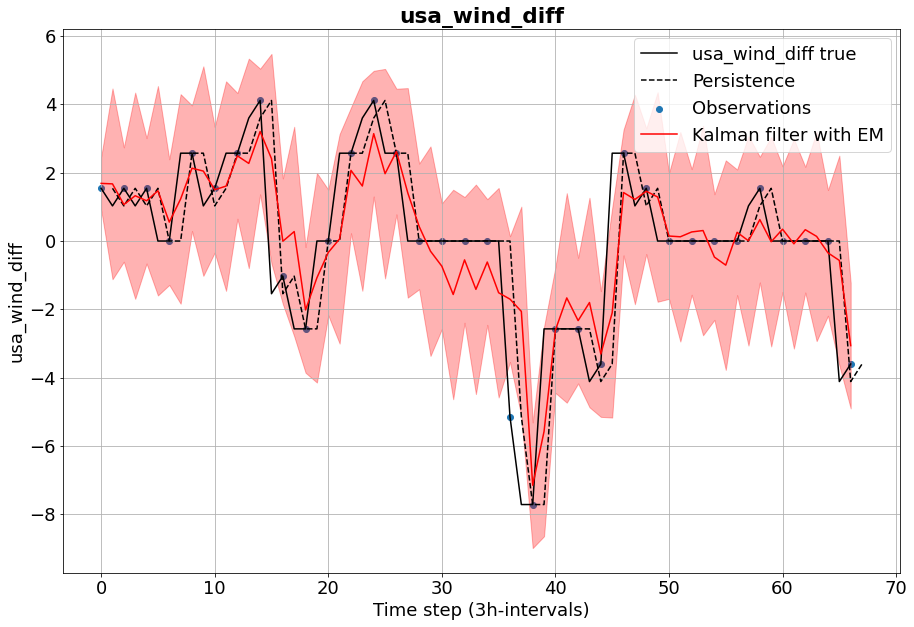

RMSE persistence   = 1.7
RMSE Kalman smooth = 0.8


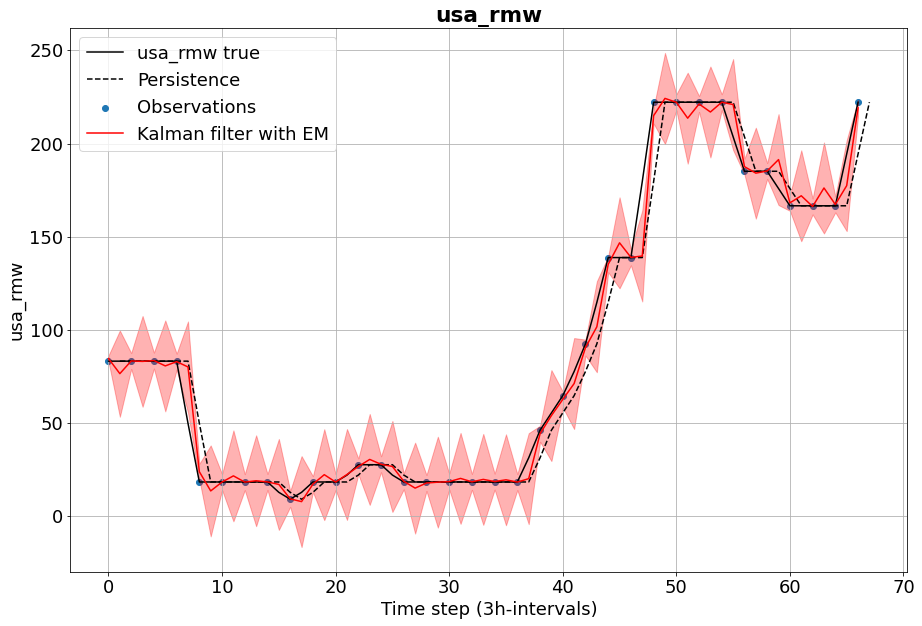

RMSE persistence   = 12.4
RMSE Kalman smooth = 2.1


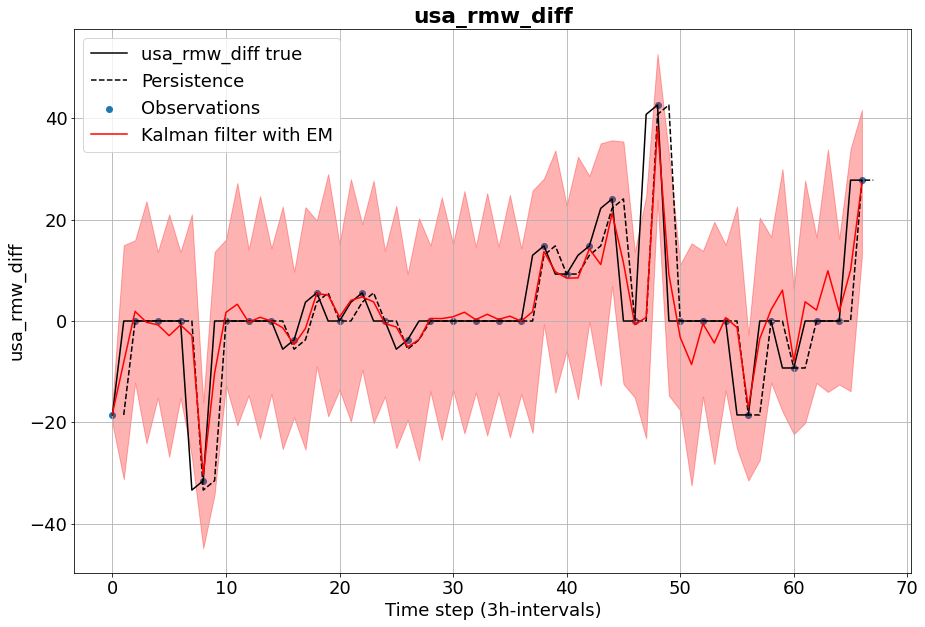

RMSE persistence   = 11.4
RMSE Kalman smooth = 2.7


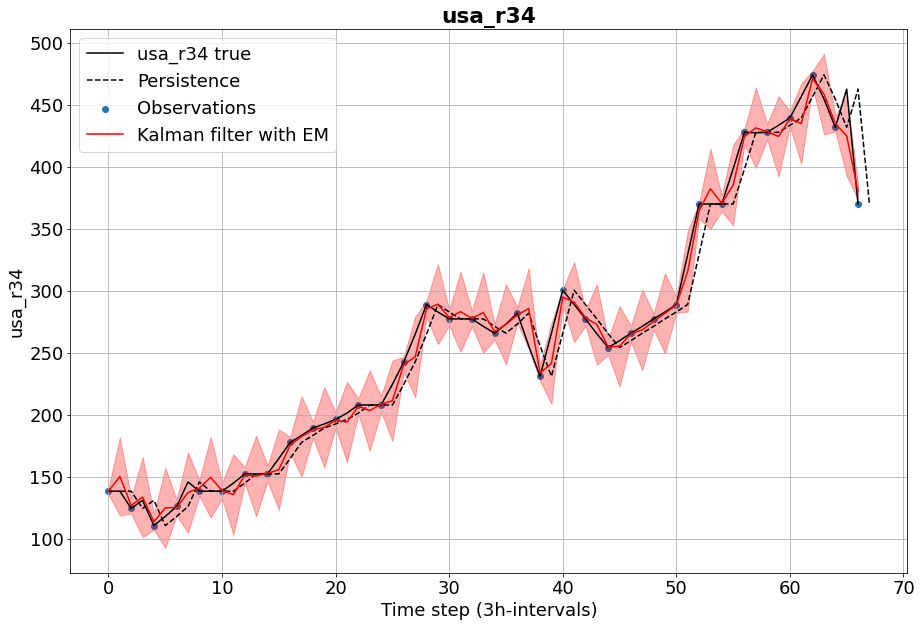

RMSE persistence   = 19.2
RMSE Kalman smooth = 7.7


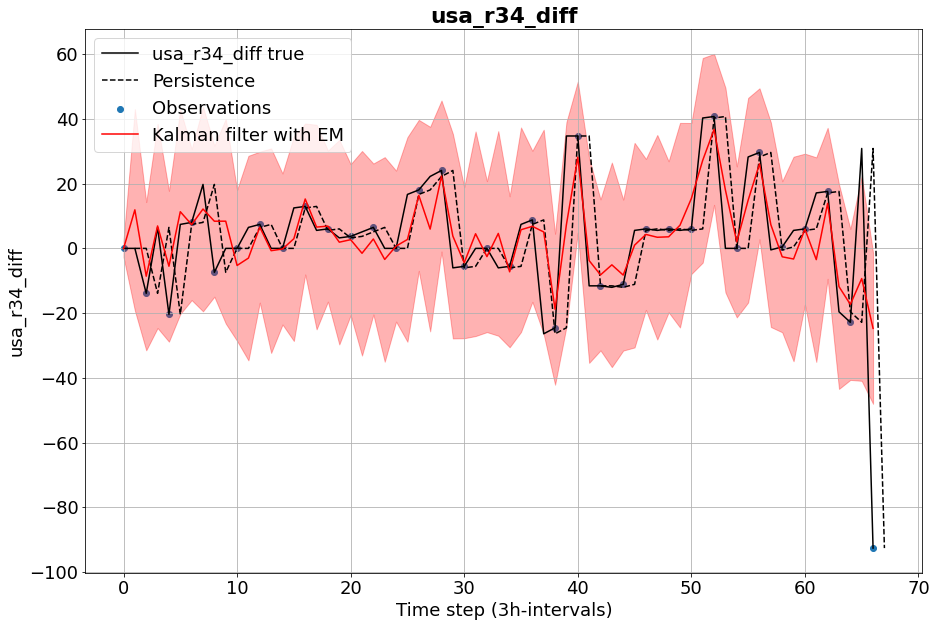

RMSE persistence   = 23.4
RMSE Kalman smooth = 11.9


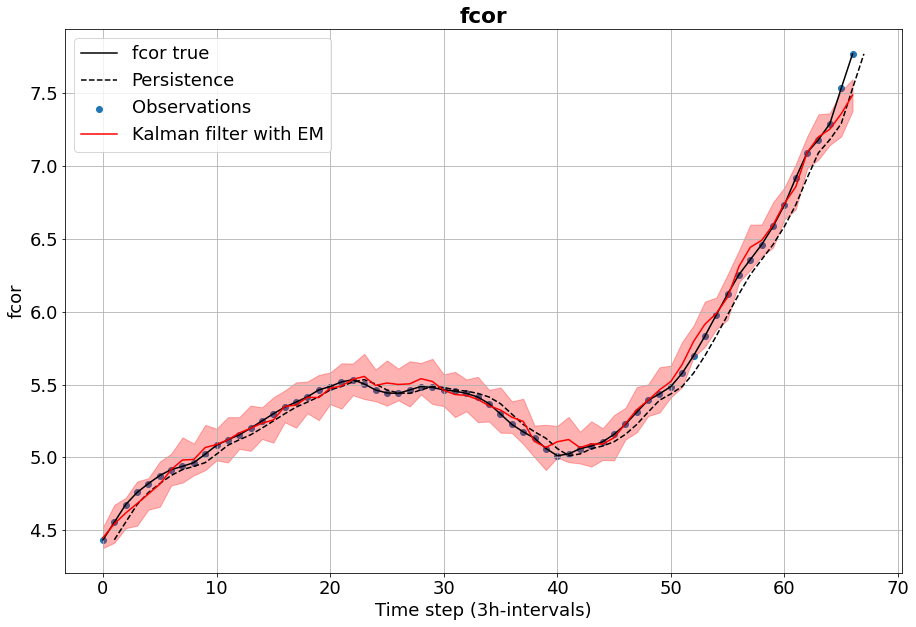

RMSE persistence   = 0.1
RMSE Kalman smooth = 0.1


In [10]:
import copy
### CREATE NOISY OBSERVATIONS
ds0  = ds_ibt.isel(storm=slice(0, 1))
X, _ = create_Xt_1_and_Xt(ds0, fcor_boost=fcor_boost)
# Create sparse observations
Y                   = copy.deepcopy(X)
mask                = np.ones(X.shape) 
mask[:, -1]         = 0 # Always keep fcor
obs_step            = 2
mask[::obs_step, :] = 0 # Keep every 4th observation

# Sparse Rmax observations
# mask[::obs_step, [0, 2, 3]] = 0 # Keep every 4th observation
# mask[::obs_step * 3, 1] = 0 # Keep very sparse observations for Rmax

Y                   = np.ma.masked_array(Y, mask=mask) # Mask every value where mask = 1

### KALMAN FILTER
# Initial conditions
x_0 = X[0, :]
P_0 = copy.deepcopy(R)

# Declare the state-space model
state_space_model = KalmanFilter(
initial_state_mean = x_0, initial_state_covariance = P_0, transition_matrices = M, transition_covariance = Q, observation_matrices = H, observation_covariance = R,
em_vars=['initial_state_mean', 'initial_state_covariance', 'transition_matrices', 'transition_covariance', 'observation_covariance'])

# Apply EM algorithm to tune x(0), P(0), M, Q and R
n_iter = 5
loglikelihoods = np.zeros(n_iter)
for i in range(len(loglikelihoods)):
    '''Bug solved by changing standard.py
    Details at https://stackoverflow.com/questions/37730850/when-using-pykalman-python-kalman-filter-what-data-type-does-loglikelihood-fu'''
    loglikelihoods[i] = state_space_model.loglikelihood(Y)
    state_space_model.em(Y, n_iter=1)
param = state_space_model

# Plot loglikelihood:
plt.title('Log-Likelihood by EM step', weight='bold')
plt.plot(loglikelihoods);plt.grid()
plt.xlabel('EM step');plt.ylabel('log-likelihood')
plt.show()

# Print the estimated parameters (e.g., Q)
print('Estimated M:')
print(str(np.around(param.transition_matrices, 2)))
print('Estimated Q:')
print(str(np.around(param.transition_covariance, 2)))
print('Estimated R:')
print(str(np.around(param.observation_covariance, 2)))

# Apply Kalman filter and smoother with the optimized parameters
x_a, P_a = state_space_model.filter(Y)
x_s, P_s = state_space_model.smooth(Y)

# Plot
for i, param in enumerate(final_params):
    plt.title(param, weight='bold')
    plt.plot(X[:, i], c='k', label='{} true'.format(param))
    plt.plot(np.arange(len(X[:, i])) + 1, X[:, i], c='k', label='Persistence', linestyle='--')
    plt.scatter(np.arange(len(X[:, i])), Y[:, i], label='Observations')
    plt.plot(x_a[:, i], c='r', label='Kalman filter with EM')
    plt.fill_between(np.arange(len(X[:, i])), x_a[:, i] - 1.96 * np.sqrt(P_a[:, i, i]), x_a[:, i] + 1.96 * np.sqrt(P_a[:, i, i]), color='r', alpha=0.3)
    
    plt.ylabel(param)
    plt.xlabel('Time step (3h-intervals)')
    plt.legend()
    plt.grid()
    # plt.savefig(PATHS['save_path'] + 'keep1obsOver{}_{}'.format(obs_step, param))
    plt.show()

    print('RMSE persistence   = {:.1f}'.format(rmse(X[:-1, i], X[1:, i])))
    print('RMSE Kalman smooth = {:.1f}'.format(rmse(x_s[:, i], X[:, i])))